In [1]:
from modules.models import FourierKawaharaPINN_noCInput, create_dense_model
from modules.data import simulate_seq2seqAmplitude
from modules.plots import plot_cParam_model, plot_training_loss
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML


2023-07-19 16:59:02.783693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [64]:
n_samples = 21
dtype = tf.float32



k = np.arange(0,n_samples,1)
k = tf.reshape(tf.convert_to_tensor(k, dtype = dtype),(n_samples,1))



y_eqn = tf.zeros((n_samples, 1))
inputs = [k]
outputs = [y_eqn] 

In [65]:
backbone = create_dense_model([64, 64, 64, 64], activation = tf.math.cos, initializer='glorot_normal', \
    n_inputs=1, n_outputs=1)

In [66]:
pinn = FourierKawaharaPINN_noCInput(backbone, alpha = 1.0, beta= 1/26. ,sigma = 1., c=0.9657002576175904, loss_residual_weight=1.)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=400, decay_rate=0.92)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)
pinn.compile(optimizer=optimizer)

In [67]:
history = pinn.fit_custom(inputs, outputs, epochs=40000, print_every=500)


Epoch 0, Loss Residual: 14058598.0000
Epoch 500, Loss Residual: 15.6341
Epoch 1000, Loss Residual: 3.0167
Epoch 1500, Loss Residual: 1.4221
Epoch 2000, Loss Residual: 0.7789
Epoch 2500, Loss Residual: 0.4587
Epoch 3000, Loss Residual: 0.2989
Epoch 3500, Loss Residual: 0.2081
Epoch 4000, Loss Residual: 0.1466
Epoch 4500, Loss Residual: 0.1010
Epoch 5000, Loss Residual: 0.0674
Epoch 5500, Loss Residual: 0.0440
Epoch 6000, Loss Residual: 0.0289
Epoch 6500, Loss Residual: 0.0199
Epoch 7000, Loss Residual: 0.0149
Epoch 7500, Loss Residual: 0.0124
Epoch 8000, Loss Residual: 0.0127
Epoch 8500, Loss Residual: 0.0115
Epoch 9000, Loss Residual: 0.0140
Epoch 9500, Loss Residual: 0.0119
Epoch 10000, Loss Residual: 0.0110
Epoch 10500, Loss Residual: 0.0107
Epoch 11000, Loss Residual: 51.5109
Epoch 11500, Loss Residual: 0.1051
Epoch 12000, Loss Residual: 0.0098
Epoch 12500, Loss Residual: 0.0093
Epoch 13000, Loss Residual: 0.0087
Epoch 13500, Loss Residual: 0.0082
Epoch 14000, Loss Residual: 0.0079


In [30]:
print(0.263524443**2, 0.23212868**2, 0.137268648**2)

0.06944513205846024 0.0538837240785424 0.018842681723747902


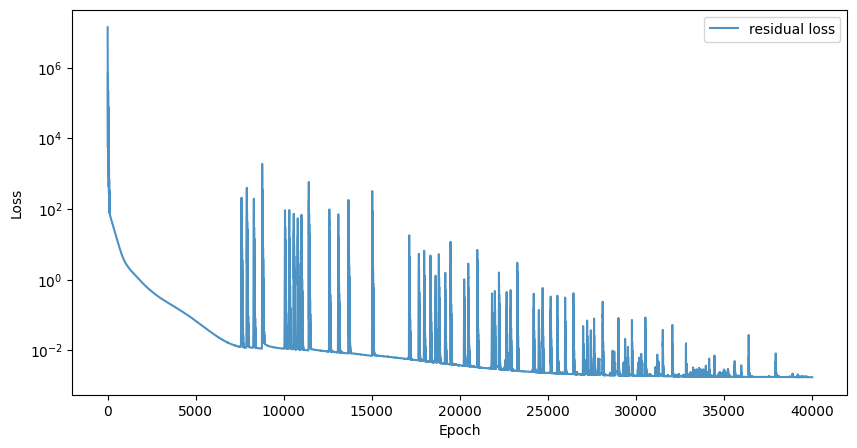

In [68]:
plot_training_loss(history, y_scale='log')

In [69]:

def plot_snapshots(model, cList, k_init, k_max, num_test_samples = 21):
    k_flat = np.linspace(k_init, k_max, num_test_samples)


    u = model.backbone.predict(k, batch_size=num_test_samples)
    plt.plot(k_flat, tf.abs(u),'.')
    plt.show()
    plt.xlabel('k')
    plt.ylabel('u(c,k)')
    plt.semilogy(k_flat, tf.abs(u),'.')
    # plt.legend()
    return u

1/1 [==============================] - 0s 183ms/step


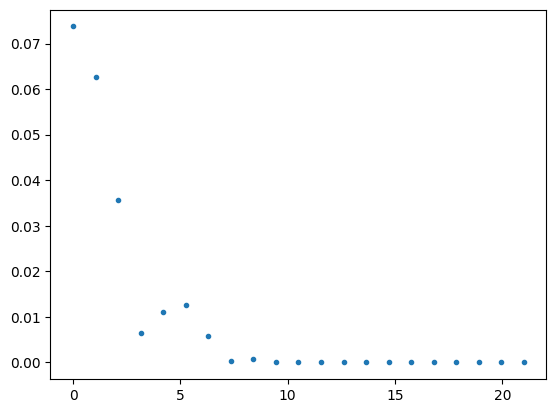

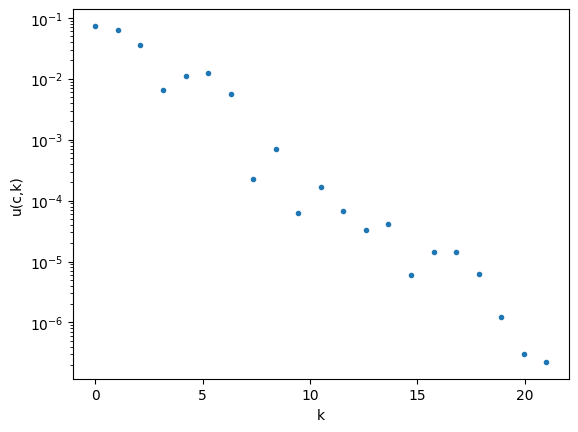

In [70]:
u = plot_snapshots(pinn, [ 0.9657], 0, 21, num_test_samples = 21)

1/1 [==============================] - 0s 51ms/step


/Users/nadiaaiaseh/Library/Python/3.9/lib/python/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


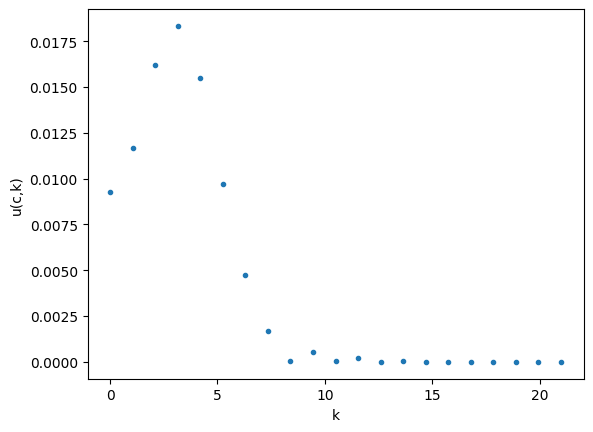

In [21]:
u = plot_snapshots(pinn, [c0], 0, 21, num_test_samples = 21)

In [47]:
ck_eqn.numpy()

array([[ 0.9411765 ,  0.        ],
       [ 0.941177  ,  1.        ],
       [ 0.9411775 ,  2.        ],
       [ 0.941178  ,  3.        ],
       [ 0.94117856,  4.        ],
       [ 0.9411791 ,  5.        ],
       [ 0.9411796 ,  6.        ],
       [ 0.9411801 ,  7.        ],
       [ 0.94118065,  8.        ],
       [ 0.9411812 ,  9.        ],
       [ 0.94118166, 10.        ],
       [ 0.9411822 , 11.        ],
       [ 0.94118273, 12.        ],
       [ 0.94118327, 13.        ],
       [ 0.94118375, 14.        ],
       [ 0.9411843 , 15.        ],
       [ 0.9411848 , 16.        ],
       [ 0.94118536, 17.        ],
       [ 0.94118583, 18.        ],
       [ 0.94118637, 19.        ],
       [ 0.9411869 , 20.        ]], dtype=float32)

In [83]:
x = np.linspace(0,2*np.pi, 101)
cos = 0
for ind, val in enumerate(u[0:3]):
    cos+= val*np.cos(ind*x)
    

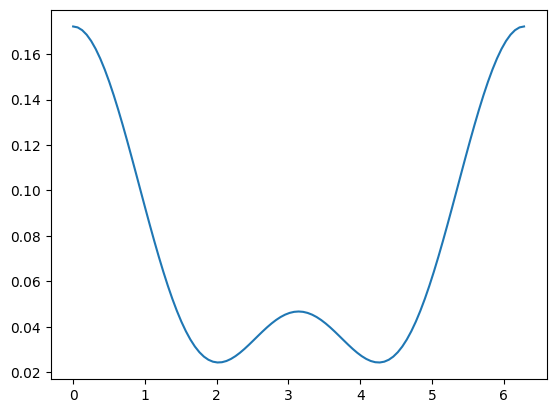

In [84]:
plt.plot(x,cos)

In [12]:
sum1_net = np.zeros((21,1))
sum2_net = np.zeros((21,1))
N= 21
a = np.ones((21,1))
for k in range(N):
    sum1 = 0.
    sum2 = 0.
    for n in range(k,N):
        sum1=sum1+a[n]*a[n-k] 
    for n in range(0,k):
        sum2=sum2+a[n]*a[k-n] 
    sum1_net[k] = sum1
    sum2_net[k] = sum2
             
    
    

In [30]:
print(tf.shape(u).numpy()[0])

21
